<center><h2 style='color:red'>HuBMAP | Pytorch | ViT for Segmentation [Train]<hr>Revised for DL Project</h2></center>

Source: https://www.kaggle.com/elcaiseri/hubmap-pytorch-vit-segmentation-starter-train

This Code depends on: <br>
- The lossses are from **https://github.com/JunMa11/SegLoss**
- The base codes are from here: **https://www.kaggle.com/vineeth1999/hubmap-pytorch-efficientunet-offline**

**Update:**
- It's the official code. https://github.com/Beckschen/TransUNet


- It's the paper of the TransUnet. https://arxiv.org/pdf/2102.04306v1.pdf (Thanks for @luciusk)


## Introduction <br>
Implementation of **self attention mechanisms** for computer vision in PyTorch with einsum and einops. Focused on **segmentation**  self-attention modules.

### Note: This is a baseline code

**Update**
- This code starts from vision 10
- **V15**: - Use DiceBCELoss - increase ViT blocks - 
- **V16**: - Apply Official code.
          - Add more options for loss function.

## Imports

In [1]:
REDUCED_SET = False

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/DLProjectData/hubmap_train_256.zip" -d "/content"

In [ ]:
!pip install albumentations==0.4.6
!pip install segmentation-models-pytorch

In [5]:
# !git clone https://github.com/Beckschen/TransUNet.git
# import sys
# sys.path.append('/content/TransUNet/')

In [6]:
!wget https://storage.googleapis.com/vit_models/imagenet21k/R50%2BViT-B_16.npz
#! pip install self-attention-cv
!pip install einops
!pip install ml_collections
# tu_path = '../input/transunet/TransUNet-main'
# sys.path.append(tu_path)

--2021-05-21 16:59:27--  https://storage.googleapis.com/vit_models/imagenet21k/R50%2BViT-B_16.npz
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.214.128, 173.194.215.128, 173.194.216.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.214.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 461217452 (440M) [application/octet-stream]
Saving to: ‘R50+ViT-B_16.npz’

R50+ViT-B_16.npz    100%[===================>] 439.85M  69.4MB/s    in 6.9s    

2021-05-21 16:59:35 (63.4 MB/s) - ‘R50+ViT-B_16.npz’ saved [461217452/461217452]

     |████████████████████████████████| 92kB 3.0MB/s 


In [7]:
# import warnings
# warnings.filterwarnings("ignore")

In [45]:
from sklearn.model_selection import GroupKFold

import torch
import torchvision
from torch import nn
from torch.optim import Adam
from torchvision import transforms
from torch.nn import functional as F
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
#from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau, CosineAnnealingWarmRestarts

import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from scipy.ndimage.interpolation import zoom

import albumentations as A
from albumentations.pytorch import ToTensorV2

import os
import sys
import time
import random

## Hyperparameters

In [46]:
class CFG:
    data = 256 #512
    debug=False
    apex=False
    print_freq=100
    num_workers=0
    img_size=256 # appropriate input size for encoder 
    scheduler='CosineAnnealingWarmRestarts' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    epoch=35 # Change epochs
    criterion= 'DiceBCELoss' #'DiceBCELoss' # ['DiceLoss', 'Hausdorff', 'Lovasz']
    base_model='Unet' # ['Unet']
    encoder = 'vit' # ['attention','efficientnet-b5'] or other encoders from smp
    lr=5e-4
    min_lr=1e-6
    batch_size=16
    weight_decay=1e-6
    gradient_accumulation_steps=1
    seed=42
    n_fold=5
    trn_fold= 0 #[0, 1, 2, 3, 4]
    train=True
    inference=False
    optimizer = 'Adam'
    T_0=10
    # N=5 
    # M=9
    T_max=10
    #factor=0.2
    #patience=4
    #eps=1e-6
    smoothing=1e-8
    in_channels=3
    vit_blocks=4 #[8, 12]
    vit_linear=512 #1024
    classes=1
    MODEL_NAME = 'R50-ViT-B_16'


main_dir = '/content'
train_dir = '/content/train'
masks_dir = '/content/masks'

In [47]:
# from @Iafoss comment
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    #the following line gives ~10% speedup
    #but may lead to some stochasticity in the results 
    torch.backends.cudnn.benchmark = True # from @Iafoss comment

seed_torch(seed=CFG.seed)

## Dataset

In [48]:
# train_df = pd.read_csv('/content/train.csv')
# train_df.head()

In [49]:
# def get_transform(mode='base'):
#     if mode == 'base':
#         base_transform = A.Compose([
#             A.Resize(CFG.img_size, CFG.img_size, p=1.0),
#             A.HorizontalFlip(),
#             A.VerticalFlip(),
#             A.RandomRotate90(),
#             A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=20, p=0.4, 
#                              border_mode=cv2.BORDER_REFLECT),
#             A.OneOf([
#                 A.OpticalDistortion(p=0.4),
#                 A.GridDistortion(p=.1),
#                 A.IAAPiecewiseAffine(p=0.4),
#             ], p=0.3),
#             A.OneOf([
#                 A.HueSaturationValue(10,15,10),
#                 A.CLAHE(clip_limit=3),
#                 A.RandomBrightnessContrast(),            
#             ], p=0.4),
#             ToTensorV2()
#         ], p=1.0)
#         return base_transform
    
#     elif mode == 'rand':
#         rand_transform = A.Compose([
#                 RandAugment(CFG.N, CFG.M),
#                 A.Transpose(p=0.5),
#                 A.VerticalFlip(p=0.5),
#                 A.HorizontalFlip(p=0.5),
#                 A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
#                 A.Resize(CFG.img_size, CFG.img_size, p=1.0),
#                 A.Normalize(),
#                 ToTensorV2()
#             ])
#         return rand_transform
    
#     elif mode == 'strong':
#         strong_transform = A.Compose([
#                 A.Transpose(p=0.5),
#                 A.VerticalFlip(p=0.5),
#                 A.HorizontalFlip(p=0.5),
#                 A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
#                 A.OneOf([
#                         A.RandomGamma(),
#                         A.GaussNoise()           
#                     ], p=0.5),
#                 A.OneOf([
#                         A.OpticalDistortion(p=0.4),
#                         A.GridDistortion(p=0.2),
#                         A.IAAPiecewiseAffine(p=0.4),
#                     ], p=0.5),
#                 A.OneOf([
#                         A.HueSaturationValue(10,15,10),
#                         A.CLAHE(clip_limit=4),
#                         A.RandomBrightnessContrast(),            
#                     ], p=0.5),

#                 A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
#                 A.Resize(CFG.img_size, CFG.img_size, p=1.0),
#                 ToTensorV2()
#             ])
#         return strong_transform
    
#     elif mode == 'weak':
#         weak_transform = A.Compose([
#                 A.Resize(CFG.img_size, CFG.img_size, p=0.5),
#                 A.HorizontalFlip(),
#                 A.VerticalFlip(),
#                 A.RandomRotate90(),
#                 A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.4, 
#                                  border_mode=cv2.BORDER_REFLECT),
#                 ToTensorV2()
#             ], p=1.0)
#         return weak_transform
    
#     elif mode == 'valid':
#         val_transform = A.Compose([
#                 A.Resize(CFG.img_size, CFG.img_size, p=1.0),
#                 ToTensorV2()
#             ], p=1.0)
#         return val_transform
    
#     else:
#         print('Unknown mode.')
    

# mean = np.array([0.65459856,0.48386562,0.69428385])
# std = np.array([0.15167958,0.23584107,0.13146145])

In [50]:
def get_train_transform():
    return A.Compose([
        A.HorizontalFlip(),
            A.OneOf([
                A.RandomContrast(),
                A.RandomGamma(),
                A.RandomBrightness(),
                ], p=0.3),
            A.OneOf([
                A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                A.GridDistortion(),
                A.OpticalDistortion(distort_limit=2, shift_limit=0.5),
                ], p=0.3),
            A.ShiftScaleRotate(p=0.2),
            A.Resize(256,256,always_apply=True),
    ],p=1.)

def get_val_transform():
    return A.Compose([
        A.Resize(256,256,always_apply=True),
    ],p=1.)

In [51]:
# class HuBMAPDataset(Dataset):
#     def __init__(self, main_dir, df, train=True, transform=None):
        
#         self.ids = df.id.values
#         self.fnames = [fname for fname in os.listdir(train_dir) if fname.split('_')[0] in self.ids]

#         self.main_dir = main_dir
#         self.df = df
#         self.train = train
#         self.transform = transform
        
#     def __len__(self):
#         return len(self.fnames)
    
#     def __getitem__(self, idx):
#         fname = self.fnames[idx]
        
#         img = cv2.cvtColor(cv2.imread(os.path.join(main_dir, 'train', fname)), cv2.COLOR_BGR2RGB)
#         mask = cv2.imread(os.path.join(main_dir, 'masks', fname),cv2.IMREAD_GRAYSCALE)
        
#         if self.transform is not None:
#             aug = self.transform(image=img, mask=mask)            
#             img, mask = aug['image'], aug['mask']
                    
#         img = img.type('torch.FloatTensor')
#         img = img/255
#         mask = mask.type('torch.FloatTensor')

#         return img, mask


class HuBMAPDataset(Dataset):
    def __init__(self, ids, phase):
        self.ids = ids
        if phase=='train':
            self.transform = get_train_transform()
        else:
            self.transform = get_val_transform()
        
    def __getitem__(self, idx):
        name = self.ids[idx]
        img = cv2.imread(os.path.join(train_dir, name)).astype("float32")[:,:,::-1] # changed path
        img /= 255.
        mask = cv2.imread(os.path.join(masks_dir, name))[:,:,0:1] # changed path

        transformed = self.transform(image=img, mask=mask)
        img = transformed['image']
        mask = transformed['mask']
        img = img.transpose(2,0,1).astype('float32')
        mask = mask.transpose(2,0,1).astype('float32')
        return img, mask

    def __len__(self):
        return len(self.ids)
          

## Visualize augmented data

In [52]:
# def vis_aug_data(dataset, length=6):
#     plt.figure(figsize=(15,10))
#     N = length // 2
#     for i in range(length):
#         image, mask = train_dataset[i]
#         plt.subplot(3,4,2*i+1)
#         plt.imshow(np.transpose((image), (1,2,0)))
#         plt.axis('off')
#         plt.subplot(3,4,2*i+2)
#         plt.imshow(mask)
#         plt.axis('off')

In [53]:
# # base augmentation
# train_dataset = HuBMAPDataset(main_dir, train_df, train=True, transform=get_transform('base'))

# vis_aug_data(train_dataset, 6)

In [54]:
# # weak augmentation
# train_dataset = HuBMAPDataset(main_dir, train_df, train=True, transform=get_transform('weak'))

# vis_aug_data(train_dataset, 6)

In [55]:
# # strong augmentation
# train_dataset = HuBMAPDataset(main_dir, train_df, train=True, transform=get_transform('strong'))

# vis_aug_data(train_dataset, 6)

In [56]:
# # valid augmentation
# train_dataset = HuBMAPDataset(main_dir, train_df, train=True, transform=get_transform('valid'))

# vis_aug_data(train_dataset, 6)

## DataLoader

In [57]:
# if CFG.data==512:
#     directory_list = os.listdir('../input/hubmap-512x512/train')
# elif CFG.data==256:
#     directory_list = os.listdir('../input/hubmap-256x256/train')

# directory_list = [fnames.split('_')[0] for fnames in directory_list]
# dir_df = pd.DataFrame(directory_list, columns=['id'])
# dir_df


directory_list = os.listdir(train_dir) # changed path
dir_df = pd.DataFrame(directory_list, columns=['Image_Paths'])

## Model

In [58]:
!rm -rf henry/

In [59]:
#!git clone https://github.com/henryw30/TransUNet.git henry
#!git clone -b mobilenet --single-branch https://github.com/henryw30/TransUNet.git henry
!git clone --branch mobilenet https://github.com/henryw30/TransUNet.git henry
sys.path.append('/content/henry/')

Cloning into 'henry'...
remote: Enumerating objects: 253, done.
remote: Counting objects: 100% (253/253), done.
remote: Compressing objects: 100% (177/177), done.
remote: Total 253 (delta 168), reused 139 (delta 75), pack-reused 0
Receiving objects: 100% (253/253), 53.15 KiB | 5.31 MiB/s, done.
Resolving deltas: 100% (168/168), done.


In [60]:
#!cd henry/ && git checkout print_main

In [61]:
from networks.vit_seg_modeling import VisionTransformer as ViT_seg
from networks.vit_seg_modeling import CONFIGS as CONFIGS_ViT_seg

config_vit = CONFIGS_ViT_seg[CFG.MODEL_NAME]
config_vit.n_classes = 1
config_vit.n_skip = 3
config_vit.pretrained_path = './R50+ViT-B_16.npz'
config_vit.transformer.dropout_rate = 0.2
config_vit.transformer.mlp_dim = 3072
config_vit.transformer.num_heads = 4
config_vit.transformer.num_layers = 8

config_vit

activation: softmax
classifier: seg
decoder_channels: !!python/tuple
- 256
- 128
- 64
- 16
hidden_size: 768
n_classes: 1
n_skip: 3
patch_size: 16
patches:
  grid: !!python/tuple
  - 16
  - 16
  size: !!python/tuple
  - 16
  - 16
pretrained_path: ./R50+ViT-B_16.npz
representation_size: null
resnet:
  num_layers: !!python/tuple
  - 3
  - 4
  - 9
  width_factor: 1
resnet_pretrained_path: null
skip_channels:
- 32
- 24
- 16
- 0
transformer:
  attention_dropout_rate: 0.0
  dropout_rate: 0.2
  mlp_dim: 3072
  num_heads: 4
  num_layers: 8

In [62]:
class ViTHuBMAP(nn.Module):
    def __init__(self, configs=config_vit):
        super(ViTHuBMAP, self).__init__()
        
        self.model = ViT_seg(configs, img_size=CFG.img_size, num_classes=CFG.classes)
        #self.model.load_from(weights=np.load(configs.pretrained_path))

    
    def forward(self, x):
        img_segs = self.model(x)
        
        return img_segs

## Loss Function

In [63]:
!git clone https://github.com/JunMa11/SegLoss.git

fatal: destination path 'SegLoss' already exists and is not an empty directory.


In [64]:
sys.path.append('/content/SegLoss')
# from losses_pytorch.hausdorff import HausdorffDTLoss
from losses_pytorch.lovasz_loss import LovaszSoftmax
# from losses_pytorch.focal_loss import FocalLoss

In [65]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=CFG.smoothing):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return dice

def getDiceScore(y_hat, y, smooth=CFG.smoothing):
    assert(y_hat.shape == y.shape)

    #comment out if your model contains a sigmoid or equivalent activation layer
    y_hat = torch.sigmoid(y_hat)

    #flatten label and prediction tensors
    y_hat = y_hat.view(-1)
    y_hat = (y_hat >= 0.5).float()
    y = y.view(-1)

    intersection = (y_hat * y).sum()                            
    dice = (2.*intersection + smooth)/(y_hat.sum() + y.sum() + smooth)  

    return dice.item()   
    
    
class DiceBCELoss(nn.Module):
    # Formula Given above.
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=CFG.smoothing):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)    

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).mean()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.mean() + targets.mean() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE.mean()
    
    
# class Hausdorff_loss(nn.Module):
#     def __init__(self):
#         super(Hausdorff_loss, self).__init__()
        
#     def forward(self, inputs, targets):
#         return HausdorffDTLoss()(inputs, targets)
    
# class FocalDLoss(nn.Module):
#     def __init__(self):
#         super(FocalDLoss, self).__init__()
        
#     def forward(self, inputs, targets):
#         return FocalLoss()(inputs, targets)
    
    
class Lovasz_loss(nn.Module):
    def __init__(self):
        super(Lovasz_loss, self).__init__()
        
    def forward(self, inputs, targets):
        return LovaszSoftmax()(inputs, targets)

In [66]:
if CFG.criterion == 'DiceBCELoss':
    criterion = DiceBCELoss()
elif CFG.criterion == 'DiceLoss':
    criterion = DiceLoss()
elif CFG.criterion == 'Lovasz':
    criterion = Lovasz_loss()
else:
    raise Exception("SLDKFJSDF")
# elif CFG.criterion == 'FocalLoss':
#     criterion = FocalDLoss()
# elif CFG.criterion == 'Hausdorff':
#     criterion = Hausdorff_loss()

## Train Function

In [67]:
def HuBMAPLoss(images, targets, model, device, loss_func=criterion):
    model.to(device)
    images = images.to(device)
    targets = targets.to(device)
    outputs = model(images)
    loss_func = loss_func
    loss = loss_func(outputs, targets)
    return loss, outputs

In [68]:
def timer(msg, reset = False):
    now = time.time();
    if not hasattr(timer, "start") or reset:
        timer.start = now;
        diff = 0;
    else:
        diff = now - timer.start;
        
    print(f"{msg} | {diff} seconds");

In [69]:
train_loss_per_epoch = []
train_score_per_epoch = []

valid_loss_per_epoch = []
valid_score_per_epoch = []

# 1st entry is the train loss, 2nd entry is the valid loss, 3rd entry is the train dice score, 4th entry is the valid dice score
fold_dict = {}

In [70]:
def train_one_epoch(epoch, model, device, optimizer, scheduler, trainloader):
    model.train()
    t = time.time()
    total_loss = 0
    dice_epoch = []
    for step, (images, targets) in enumerate(trainloader):
        # run model and get loss
        loss, outputs = HuBMAPLoss(images, targets, model, device)
        loss.backward()
        if ((step+1)%4==0 or (step+1)==len(trainloader)):
            optimizer.step()
            #scheduler.step()
            optimizer.zero_grad()

        loss = loss.detach().item()
        total_loss += loss

        # get dice score
        dice_batch = getDiceScore(outputs, targets.to(device))
        dice_epoch.append(dice_batch)
        
        # if ((step+1)%10==0 or (step+1)==len(trainloader)):
        #     print(
        #             f'epoch {epoch} train step {step+1}/{len(trainloader)}, ' + \
        #             f'loss: {total_loss/len(trainloader):.4f}, ' + \
        #             f'time: {(time.time() - t):.4f}', end= '\r' if (step + 1) != len(trainloader) else '\n'
        #         )

    # print stuff
    print(
            f'epoch {epoch}, ' + \
            f'loss: {total_loss/len(trainloader):.4f}, ' + \
            f'time: {(time.time() - t):.4f}, '  + \
            f'dice: {np.mean(dice_epoch)}', end='\n'
        )
    
    return total_loss/len(trainloader), np.mean(dice_epoch)
            
        
def valid_one_epoch(epoch, model, device, optimizer, scheduler, validloader):
    model.eval()
    t = time.time()
    total_loss = 0
    dice_epoch = []
    for step, (images, targets) in enumerate(validloader):
        # run model and get loss
        loss, outputs = HuBMAPLoss(images, targets, model, device)
        loss = loss.detach().item()
        total_loss += loss
        
        # if ((step+1)%4==0 or (step+1)==len(validloader)):
        #     scheduler.step(total_loss/len(validloader))

        # get dice score
        dice_batch = getDiceScore(outputs, targets.to(device))
        dice_epoch.append(dice_batch)
        
        # if ((step+1)%10==0 or (step+1)==len(validloader)):
        #     print(
        #             f'**epoch {epoch} trainz step {step+1}/{len(validloader)}, ' + \
        #             f'loss: {total_loss/len(validloader):.4f}, ' + \
        #             f'time: {(time.time() - t):.4f}', end= '\r' if (step + 1) != len(validloader) else '\n'
        #         )

    # print stuff       
    print(
            f'epoch {epoch}, ' + \
            f'loss: {total_loss/len(trainloader):.4f}, ' + \
            f'time: {(time.time() - t):.4f}, '  + \
            f'dice: {np.mean(dice_epoch)}', end='\n'
        )
    return total_loss/len(validloader), np.mean(dice_epoch)

## Creating Folds Column

In [71]:
FOLDS = CFG.n_fold
gkf = GroupKFold(FOLDS)
dir_df['Folds'] = 0
for fold, (tr_idx, val_idx) in enumerate(gkf.split(dir_df, groups=dir_df[dir_df.columns[0]].values)):
    dir_df.loc[val_idx, 'Folds'] = fold
    
dir_df

,Image_Paths,Folds
0,4ef6695ce_0764.png,1
1,cb2d976f4_1019.png,1
2,54f2eec69_0471.png,1
3,b2dc8411c_0243.png,0
4,8242609fa_0102.png,3
...,...,...
9575,095bf7a1f_1018.png,4
9576,cb2d976f4_1007.png,2
9577,095bf7a1f_0687.png,3
9578,afa5e8098_0877.png,3


## The Real Training

In [72]:
# def prepare_train_valid_dataloader(df, fold):
#     train_ids = df[~df.Folds.isin(fold)]
#     val_ids = df[df.Folds.isin(fold)]
    
#     train_ds = HuBMAPDataset(main_dir, train_ids, train=True, transform=get_transform('base'))
#     val_ds = HuBMAPDataset(main_dir, val_ids, train=True, transform=get_transform('valid'))
    
#     train_loader = DataLoader(train_ds, batch_size=CFG.batch_size, pin_memory=True, shuffle=True, num_workers=CFG.num_workers)
#     val_loader = DataLoader(val_ds, batch_size=CFG.batch_size, pin_memory=True, shuffle=False, num_workers=CFG.num_workers)
    
#     return train_loader, val_loader



def prepare_train_valid_dataloader(df, fold):
    train_ids = df.loc[~df.Folds.isin(fold), "Image_Paths"].values
    val_ids = df.loc[df.Folds.isin(fold), "Image_Paths"].values

    train_ds = HuBMAPDataset(train_ids, "train")
    val_ds = HuBMAPDataset(val_ids, "val")

    train_loader = DataLoader(train_ds, batch_size=CFG.batch_size, pin_memory=True, shuffle=True, num_workers=CFG.num_workers)
    val_loader = DataLoader(val_ds, batch_size=CFG.batch_size, pin_memory=True, shuffle=False, num_workers=CFG.num_workers)

    return train_loader, val_loader

In [73]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ViTHuBMAP().to(device)
optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)

# scheduler setting
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=1)
# if CFG.scheduler == 'CosineAnnealingWarmRestarts':
#     scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
# elif CFG.scheduler == 'ReduceLROnPlateau':
#     scheduler = ReduceLROnPlateauReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
# elif CFG.scheduler == 'CosineAnnealingLR':
#     scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)

In [74]:
timer("starting training", reset = True);
for fold, (tr_idx, val_idx) in enumerate(gkf.split(dir_df, groups=dir_df[dir_df.columns[0]].values)):
    timer(f"{fold} fold loop")
    if fold >= 1: # think this is just doing 1 cross validation ...
        break
        
    trainloader, validloader = prepare_train_valid_dataloader(dir_df, [fold])
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model = ViTHuBMAP().to(device)
    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=1)
    
    
    for epoch in range(CFG.epoch):
        # train
        train_loss, train_score = train_one_epoch(epoch, model, device, optimizer, scheduler, trainloader)
        train_loss_per_epoch.append(train_loss)
        train_score_per_epoch.append(train_score)

        # validate
        with torch.no_grad():
            valid_loss, valid_score = valid_one_epoch(epoch, model, device, optimizer, scheduler, validloader)
            valid_loss_per_epoch.append(valid_loss)
            valid_score_per_epoch.append(valid_score)
        
    fold_dict[fold] = (train_loss_per_epoch, valid_loss_per_epoch, train_score_per_epoch, valid_score_per_epoch)

    train_loss_per_epoch = []
    train_score_per_epoch = []
    valid_loss_per_epoch = []
    valid_score_per_epoch = []
    
    # save state per fold
    torch.save(model.state_dict(), f'FOLD-{fold}-model.pth')

    timer(f"{fold} done fold")

starting training | 0 seconds
0 fold loop | 0.03366208076477051 seconds


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch 0, loss: 1.1128, time: 259.7856, dice: 0.38694177690243525
epoch 0, loss: 0.2429, time: 24.0231, dice: 0.35664160770053666
epoch 1, loss: 0.6534, time: 260.5013, dice: 0.5402831711528329
epoch 1, loss: 0.1315, time: 24.1089, dice: 0.6156778008987506
epoch 2, loss: 0.5274, time: 262.9041, dice: 0.6019102820974929
epoch 2, loss: 0.1312, time: 24.1313, dice: 0.5968699588129918
epoch 3, loss: 0.4857, time: 262.5863, dice: 0.6256006540641158
epoch 3, loss: 0.1185, time: 24.0003, dice: 0.6403892715771993
epoch 4, loss: 0.4517, time: 261.9234, dice: 0.6505310000746758
epoch 4, loss: 0.0996, time: 23.9387, dice: 0.6922837257715098
epoch 5, loss: 0.4205, time: 260.1748, dice: 0.6747255923852542
epoch 5, loss: 0.2430, time: 23.9914, dice: 0.3435347641197344
epoch 6, loss: 0.4046, time: 260.3122, dice: 0.6857719347386494
epoch 6, loss: 0.0881, time: 23.9356, dice: 0.7301266599446535
epoch 7, loss: 0.3936, time: 260.2022, dice: 0.6928588542348407
epoch 7, loss: 0.0870, time: 24.0105, dice: 0

In [75]:
# print(f'Training Loop [{CFG.trn_fold}]...')
# for fold, (tr_idx, val_idx) in enumerate(gkf.split(dir_df, groups=dir_df[dir_df.columns[0]].values)):
#     # if fold != CFG.trn_fold: # Train only one fold
#     #     continue 

#     trainloader, validloader = prepare_train_valid_dataloader(dir_df, [fold])

#     for epoch in range(CFG.epoch):
#         train_one_epoch(epoch, model, device, optimizer, scheduler, trainloader)
#         with torch.no_grad():
#             valid_one_epoch(epoch, model, device, optimizer, scheduler, validloader)
        
#         #torch.save(model.state_dict(),f'FOLD-{fold}-EPOCH-{epoch}-model.pth')
        
#     torch.save(model.state_dict(),f'FOLD-{fold}-model.pth')
    
#     #del model, optimizer, scheduler, trainloader, validloader

In [76]:
import matplotlib.pyplot as plt

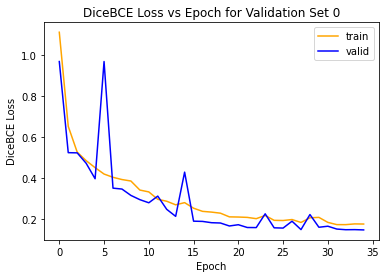

In [77]:
# loss score for epochs only

for i in range(1):
    plt.plot(fold_dict[i][0], label='train', color = 'orange')
    plt.plot(fold_dict[i][1], label='valid', color='blue')

    plt.xlabel('Epoch')
    plt.ylabel('DiceBCE Loss')

    plt.title("DiceBCE Loss vs Epoch for Validation Set {0}".format(i))
    plt.legend()
    plt.show()

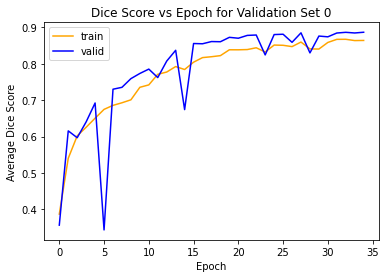

In [78]:
# dice score for epochs only

for i in range(1):
    plt.plot(fold_dict[i][2], label='train', color = 'orange')
    plt.plot(fold_dict[i][3], label='valid', color='blue')

    plt.xlabel('Epoch')
    plt.ylabel('Average Dice Score')

    plt.title("Dice Score vs Epoch for Validation Set {0}".format(i))
    plt.legend()
    plt.show()

## Plot the results 

In [79]:
# trainloader, validloader = prepare_train_valid_dataloader(dir_df, [4])

In [80]:
# def plot_result(validloader, n_sample=4):
#     img, mask = next(iter(validloader))
#     model.load_state_dict(torch.load(f'./FOLD-{CFG.trn_fold}-model.pth'))
#     pred_mask = model(img.to(device)).squeeze(1).cpu().detach()
    
#     N = n_sample // 2
#     assert (N < CFG.batch_size)
#     plt.figure(figsize=(15, 20))
#     for i in range(n_sample):
#         plt.subplot(N, 4, 2*i+1)
#         plt.imshow(np.transpose(img[i], (1,2,0)))
#         plt.axis('off')
        
#         plt.subplot(N, 4, 2*i+2)
#         plt.imshow(pred_mask[i])
#         plt.axis('off')

In [81]:
# with torch.no_grad():
#     plot_result(validloader)

## What you should do to improve the results:
- Use data normalization
- Use anthor implementation for TransUnet (Applied in V16)
- Reduce the probability of the augmentations
- Play with visionTrans hyperparameters

<CENTER><h3><span style='color:red'> UPVOTE </span> If you liked</h3>
<h4>Code still under modifications, Stay tuned</h4></CENTER>